In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

/Users/lyidacao/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
trainData = pd.read_csv("data/train.csv")

In [4]:
testData = pd.read_csv("data/test.csv")

In [6]:
all_df=pd.concat([trainData,testData], ignore_index=True,sort=False)
all_df


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


Text(0.5, 1.0, 'The percentage of missing values per column')

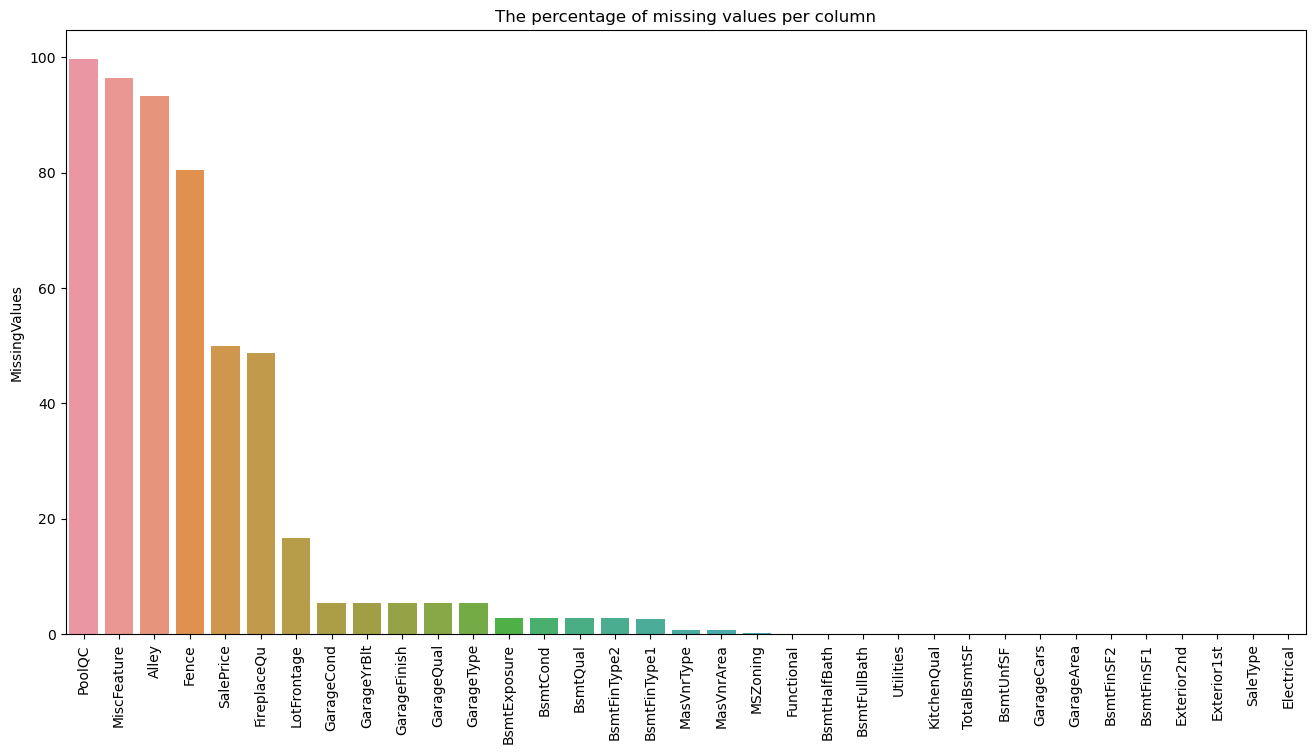

In [5]:
missings_df={}
for key in all_df.columns:
    if all_df[key].isnull().sum() > 0:
        missings_df[key]=(all_df[key].isnull().sum()  /  len(all_df[key]) ) * 100

#Create missing values dataframe
missings_df=pd.DataFrame(missings_df,index=['MissingValues']).T.sort_values(by='MissingValues',ascending=False)


#Plotting number of missing values per column
plt.figure(figsize=(16,8),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.MissingValues,x=missings_df.index, orient='v').set_title('The percentage of missing values per column')
#dpi=100 orient='v'

### Deep dive into missing values

#### Checking categoricals first

In [6]:
tmp_bool = all_df['PoolQC'].isna()
#tep_bool 含义?
all_df.loc[tmp_bool, ['PoolQC', 'PoolArea']]
#这里是求poolqc na 时 poolarea?

,PoolQC,PoolArea
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
2914,NaN,0
2915,NaN,0
2916,NaN,0
2917,NaN,0


In [7]:
tmp_bool = (all_df['PoolQC'].isna() & all_df['PoolArea']>0)
all_df.loc[tmp_bool, ['PoolQC', 'PoolArea']]

,PoolQC,PoolArea
2599,NaN,561


In [8]:
tmp_bool = all_df['FireplaceQu'].isna()
all_df.loc[tmp_bool, ['FireplaceQu', 'Fireplaces']]

,FireplaceQu,Fireplaces
0,NaN,0
5,NaN,0
10,NaN,0
12,NaN,0
15,NaN,0
...,...,...
2912,NaN,0
2913,NaN,0
2914,NaN,0
2915,NaN,0


In [9]:
tmp_bool = (all_df['FireplaceQu'].isna() & all_df['Fireplaces']>0)
all_df.loc[tmp_bool, ['FireplaceQu', 'Fireplaces']]

,FireplaceQu,Fireplaces


In [10]:
tmp_bool = all_df['GarageQual'].isna()
all_df.loc[tmp_bool, ['GarageQual', 'GarageCars']]

,GarageQual,GarageCars
39,NaN,0.0
48,NaN,0.0
78,NaN,0.0
88,NaN,0.0
89,NaN,0.0
...,...,...
2893,NaN,0.0
2909,NaN,0.0
2913,NaN,0.0
2914,NaN,0.0


In [15]:
tmp_bool = (all_df['GarageQual'].isna() & all_df['GarageCars']>0)
all_df.loc[tmp_bool, ['GarageQual', 'GarageCars']]
#这一行没处理？

,GarageQual,GarageCars


- After reading the data description and some sanity check we can fill some of the missing categorical features with 'None', and some with most frequent category.

In [12]:
# Fill with None
fill_cols = ['Alley',
            'PoolQC',
            'Fence',
            'MiscFeature',
            'FireplaceQu',
            'GarageCond',
            'GarageQual',
            'GarageFinish',
            'GarageType',
            'BsmtExposure',
            'BsmtFinType2',
            'BsmtFinType1',
            'BsmtQual',
            'BsmtCond', 
            'MasVnrType']
for col in fill_cols:
    all_df[col].fillna('None', inplace=True)
    #none是有意义的

In [14]:
# Fill with most frequent value
fill_cols = ['Electrical',
            'MSZoning',
            'Utilities',
            'Functional',
            'SaleType',
            'Exterior2nd',
            'Exterior1st',
            'KitchenQual']
for col in fill_cols:
    all_df[col].fillna(all_df[col].mode()[0], inplace=True)

In [52]:
all_df['Utilities'].mode()

0    AllPub
Name: Utilities, dtype: object

#### Checking numericals now

In [17]:
all_df.columns[all_df.isna().any()]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')

In [18]:
# Now we only have 11 numerical variables left with any missing values
num_cols = all_df.columns[all_df.isna().any()]

In [19]:
#Checking the 11 variables with missing values and sort by count
all_df[num_cols].describe().T.sort_values(by='count')
#all_df.isnull().sum().sort_values(ascending=False).head(12)

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
GarageYrBlt,2760.0,1978.113406,25.574285,1895.0,1960.0,1979.0,2002.0,2207.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFullBath,2917.0,0.429894,0.524736,0.0,0.0,0.0,1.0,3.0
BsmtHalfBath,2917.0,0.061364,0.245687,0.0,0.0,0.0,0.0,2.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0
BsmtUnfSF,2918.0,560.772104,439.543659,0.0,220.0,467.0,805.5,2336.0
TotalBsmtSF,2918.0,1051.777587,440.766258,0.0,793.0,989.5,1302.0,6110.0


##### Only 'LotFrontage', 'GarageYrBlt', 'MasVnrArea' have decent amont of missing values, for the others, we can fill with zero.

In [20]:
fill_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
'GarageCars', 'GarageArea']
for col in fill_cols:
    all_df[col] = all_df[col].fillna(0)

#### LotFrontage:
Let's try using model to fill the missing Lot Frontage. From the previous correlation heatmap, we know that LotArea and 1stFlrSF are highly correlated with LotFrontage

In [21]:
tmp_df = all_df[~all_df['LotFrontage'].isna()]

<AxesSubplot:xlabel='1stFlrSF', ylabel='Count'>

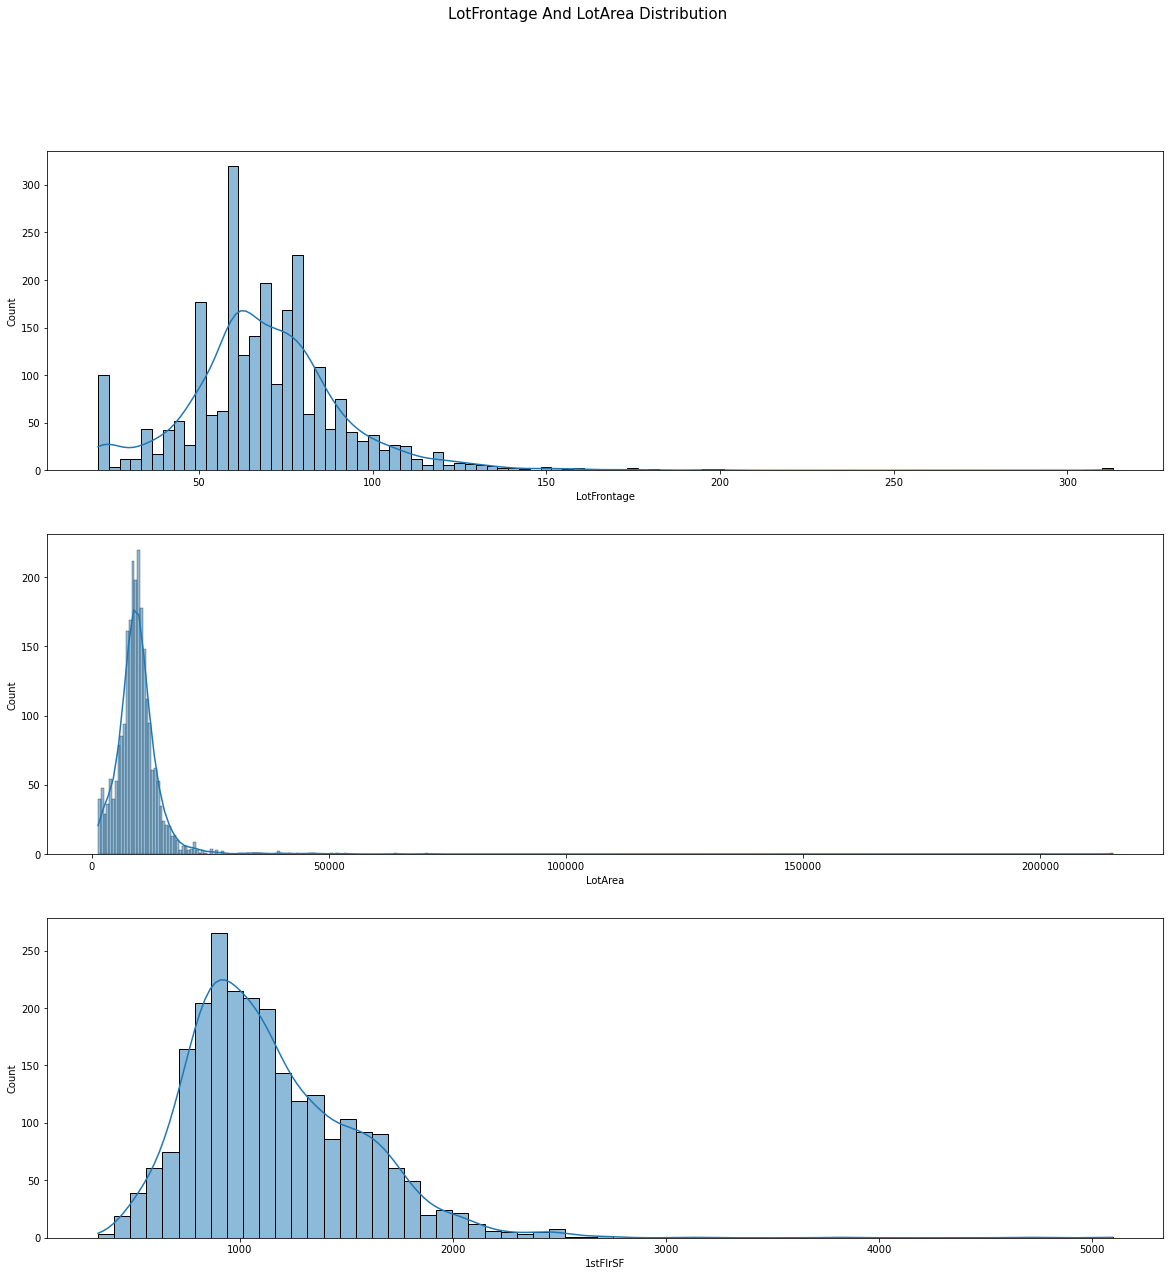

In [22]:
fig,ax = plt.subplots(3,1, figsize=(20,20))
fig.suptitle('LotFrontage And LotArea Distribution',size=15)
sns.histplot(x=tmp_df['LotFrontage'],kde=True, ax=ax[0])
sns.histplot(x=tmp_df['LotArea'],kde=True, ax=ax[1])
sns.histplot(x=tmp_df['1stFlrSF'],kde=True, ax=ax[2])

We can see that LotArea has a different distribution, let's try take a square root of the area

<AxesSubplot:xlabel='1stFlrSF', ylabel='Count'>

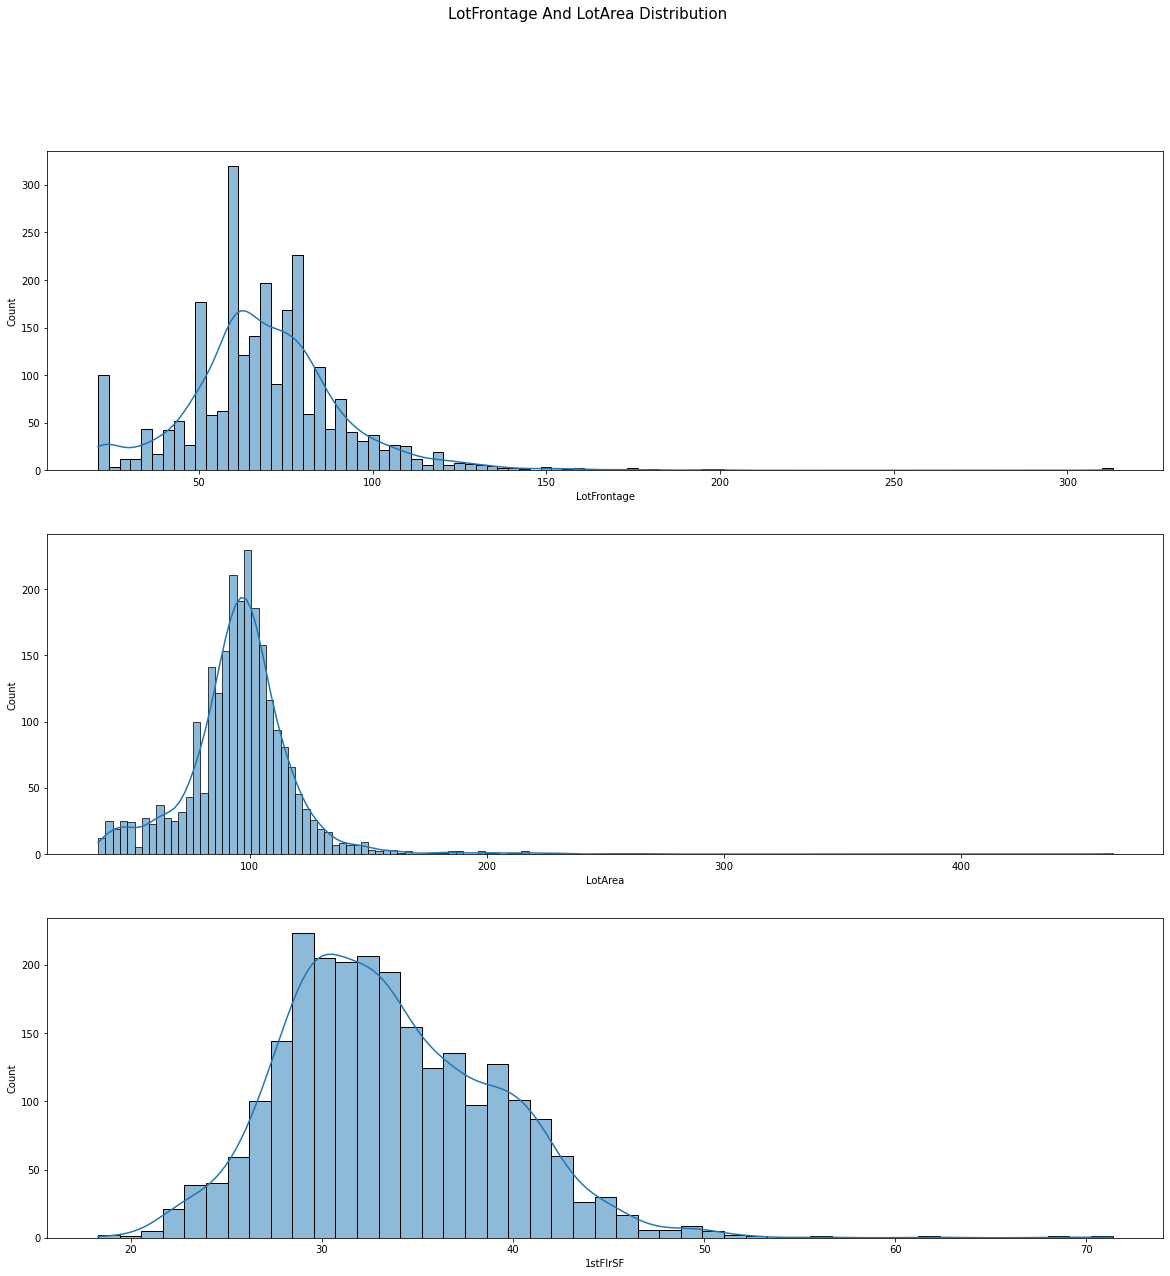

In [24]:
fig,ax = plt.subplots(3,1, figsize=(20,20))
fig.suptitle('LotFrontage And LotArea Distribution',size=15)
sns.histplot(x=tmp_df['LotFrontage'],kde=True, ax=ax[0])
sns.histplot(x=tmp_df['LotArea'].apply(np.sqrt),kde=True, ax=ax[1])
sns.histplot(x=tmp_df['1stFlrSF'].apply(np.sqrt),kde=True, ax=ax[2])

In [25]:
# Removing outliers
from scipy import stats
z = np.abs(stats.zscore(tmp_df[['LotFrontage', 'LotArea', '1stFlrSF']]))
tmp_df = tmp_df[(z<3).all(axis=1)]

[Text(0.5, 1.0, 'Relation Between LotFrontage And Sqrt(LotArea)')]

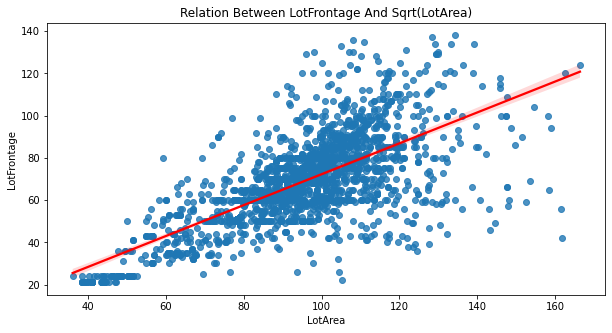

In [26]:
plt.figure(figsize=(10,5))
sns.regplot(x=tmp_df.LotArea.apply(np.sqrt),y=tmp_df.LotFrontage,
            line_kws={"color": "red"}).set(title='Relation Between LotFrontage And Sqrt(LotArea)')


[Text(0.5, 1.0, 'Relation Between LotFrontage And 1stFlrSF')]

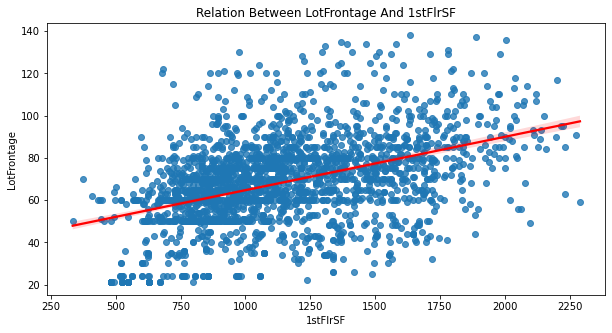

In [27]:
plt.figure(figsize=(10,5))
sns.regplot(x=tmp_df['1stFlrSF'],y=tmp_df.LotFrontage,
            line_kws={"color": "red"}).set(title='Relation Between LotFrontage And 1stFlrSF')

Now let's pick a few categorical inputs as well

Text(0.5, 1.0, 'Neighborhood and LotFrontage')

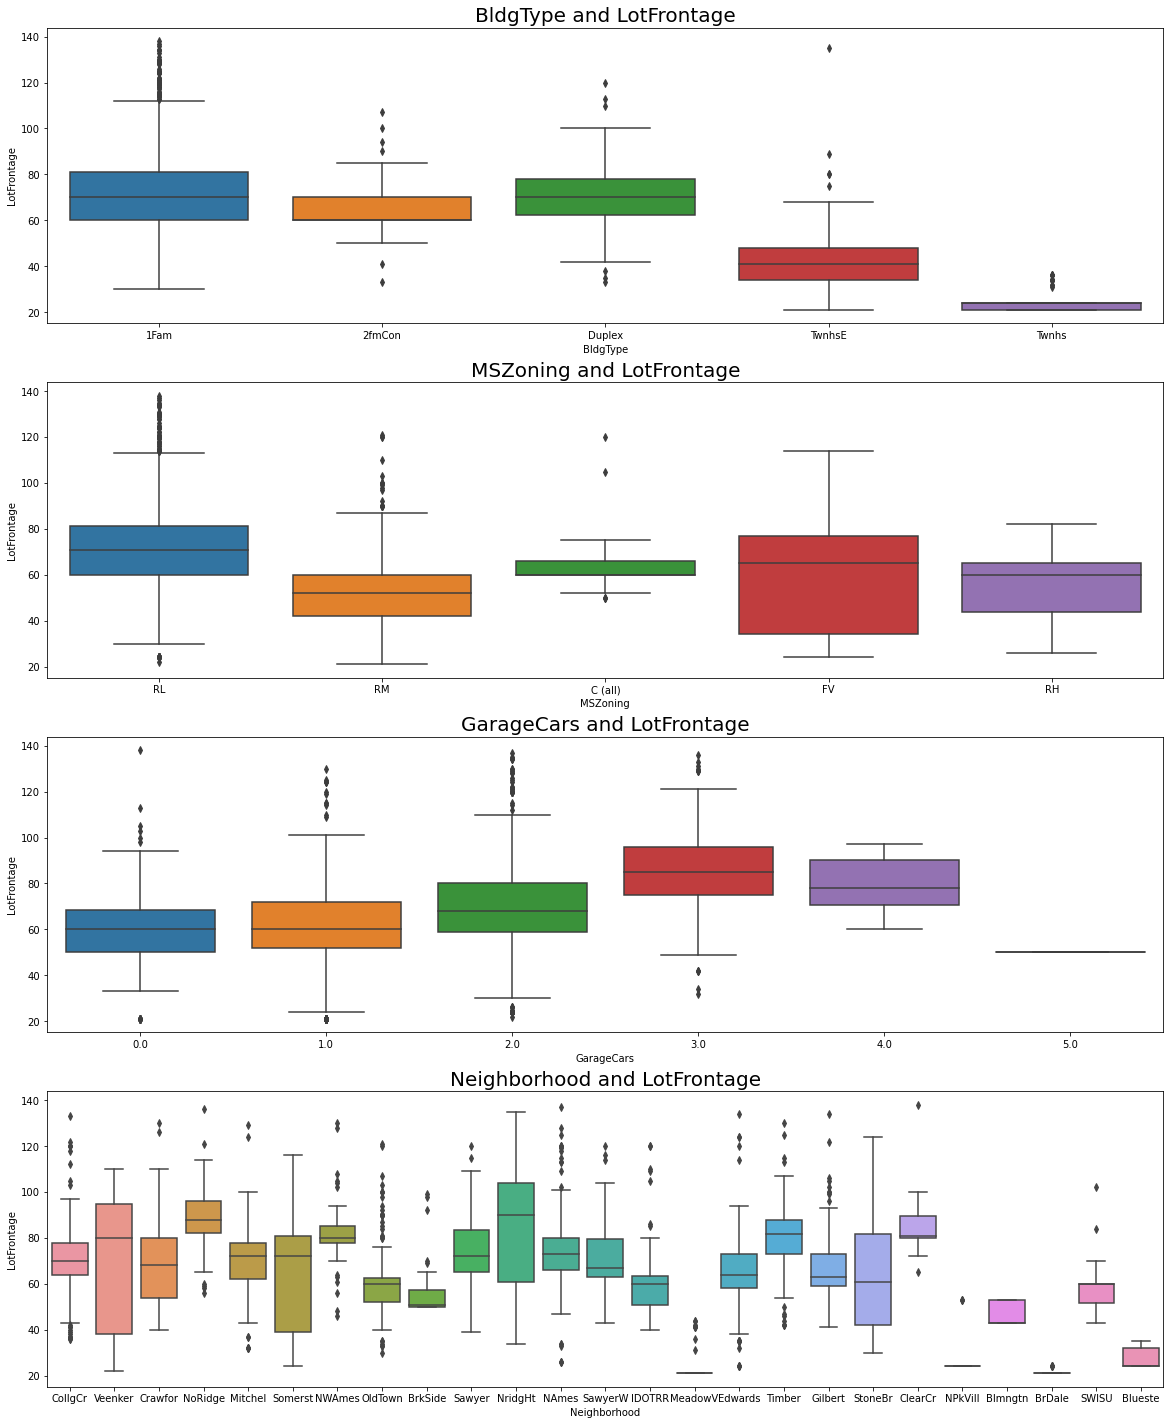

In [28]:
#Relation between BldgType and LotFrontage
fig,ax = plt.subplots(4,1, figsize=(20,25))
sns.boxplot(x=all_df.BldgType,y=tmp_df.LotFrontage, ax=ax[0]).set_title('BldgType and LotFrontage',fontsize = 20)
sns.boxplot(x=all_df.MSZoning,y=tmp_df.LotFrontage, ax=ax[1]).set_title('MSZoning and LotFrontage',fontsize = 20)
sns.boxplot(x=all_df.GarageCars,y=tmp_df.LotFrontage, ax=ax[2]).set_title('GarageCars and LotFrontage',fontsize = 20)
sns.boxplot(x=all_df.Neighborhood,y=tmp_df.LotFrontage, ax=ax[3]).set_title('Neighborhood and LotFrontage',fontsize = 20)


Now we start building model using these avariables to predict LotFrontage

In [29]:
df2 = all_df[['LotFrontage', 'LotArea', '1stFlrSF', 'BldgType', 'MSZoning', 'GarageCars', 'Neighborhood']].copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   2433 non-null   float64
 1   LotArea       2919 non-null   int64  
 2   1stFlrSF      2919 non-null   int64  
 3   BldgType      2919 non-null   object 
 4   MSZoning      2919 non-null   object 
 5   GarageCars    2919 non-null   float64
 6   Neighborhood  2919 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 159.8+ KB


In [30]:
df2

,LotFrontage,LotArea,1stFlrSF,BldgType,MSZoning,GarageCars,Neighborhood
0,65.0,8450,856,1Fam,RL,2.0,CollgCr
1,80.0,9600,1262,1Fam,RL,2.0,Veenker
2,68.0,11250,920,1Fam,RL,2.0,CollgCr
3,60.0,9550,961,1Fam,RL,3.0,Crawfor
4,84.0,14260,1145,1Fam,RL,3.0,NoRidge
...,...,...,...,...,...,...,...
2914,21.0,1936,546,Twnhs,RM,0.0,MeadowV
2915,21.0,1894,546,TwnhsE,RM,1.0,MeadowV
2916,160.0,20000,1224,1Fam,RL,2.0,Mitchel
2917,62.0,10441,970,1Fam,RL,0.0,Mitchel


In [31]:
pd.get_dummies(df2['BldgType'])

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2914,0,0,0,1,0
2915,0,0,0,0,1
2916,1,0,0,0,0
2917,1,0,0,0,0


In [32]:
# Apply square root to LotArea
df2['LotArea']=np.sqrt(df2['LotArea'])

In [33]:
# Create dummies for categorical variables
df2 = pd.get_dummies(df2)

In [34]:
# Dividing training and testing set
tmp_bool = ~df2['LotFrontage'].isna()

df_train=df2.loc[tmp_bool]
df_test=df2.loc[~tmp_bool].drop('LotFrontage',axis=1)

# Drop outliers
z = np.abs(stats.zscore(df_train[['LotFrontage', 'LotArea', '1stFlrSF']]))
df_train = df_train[(z<3).all(axis=1)]

X = df_train.drop('LotFrontage',axis=1)
y = df_train['LotFrontage']

#Split the train set
x_train,x_valid,y_train,y_valid=train_test_split(X, y ,test_size=0.3 , random_state=88)


In [35]:
#Defining model
model=XGBRegressor(n_estimators= 12)

In [36]:
model.fit(x_train,y_train)

/Users/lyidacao/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=12, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [37]:
#predicting validation target
y_pred=model.predict(x_valid)

In [38]:
#Storing mean absolute error for single mean, median and Gradien Boosting Regressor
XGBoost_results= mean_absolute_error(y_valid,y_pred)
Mean_result= mean_absolute_error(y_valid,[y_valid.mean()]*len(y_valid))
Median_result= mean_absolute_error(y_valid,[y_valid.median()]*len(y_valid))
print("MEAN ABSOLUTE ERROR : ", XGBoost_results)

MEAN ABSOLUTE ERROR :  8.269356054811626


[Text(0.5, 1.0, 'LotFrontage Imputation - Mean/Median Vs. GradientBooster'),
 Text(0, 0.5, 'Mean absolute error')]

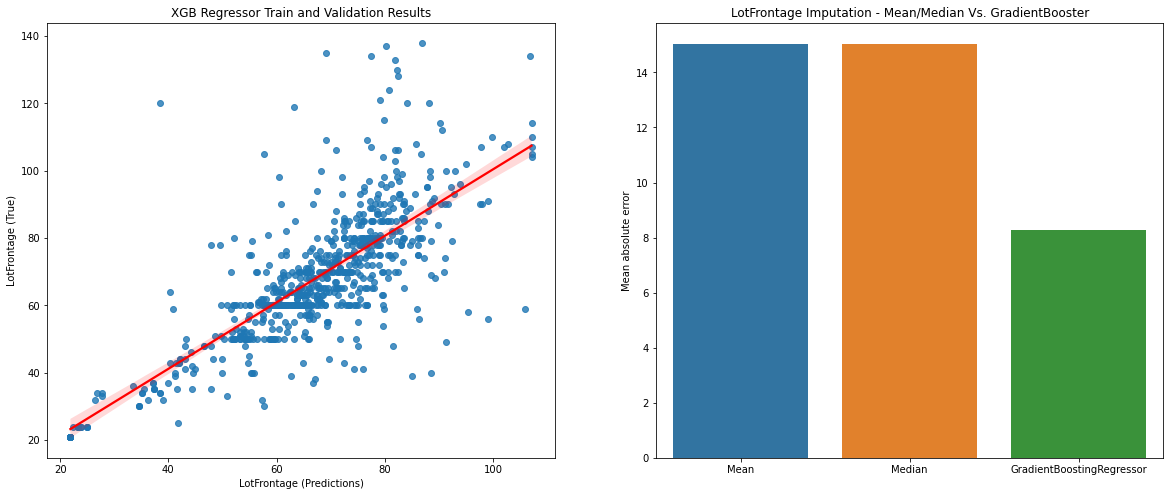

In [39]:
#Plotting train/validation results and MAE report
fig, ax= plt.subplots(1,2,figsize=(20,8))

sns.regplot(x=y_pred,y=y_valid, line_kws={'color':'red'} , ax=ax[0]).set(title='XGB Regressor Train and Validation Results',xlabel='LotFrontage (Predictions)',ylabel='LotFrontage (True)')
sns.barplot(x=["Mean","Median","GradientBoostingRegressor"],y=[Mean_result,Median_result,XGBoost_results], ax=ax[1]).set(title='LotFrontage Imputation - Mean/Median Vs. GradientBooster',ylabel='Mean absolute error')

In [40]:
predicted = model.predict(df_test)

In [41]:
all_df.loc[~tmp_bool, 'LotFrontage'] = predicted

#### GarageYrBlt

In [42]:
# Cheking GarageType where GarageYrBlt is missing 
all_df[['GarageYrBlt','GarageType']].loc[all_df.GarageYrBlt.isna()]

,GarageYrBlt,GarageType
39,NaN,None
48,NaN,None
78,NaN,None
88,NaN,None
89,NaN,None
...,...,...
2893,NaN,None
2909,NaN,None
2913,NaN,None
2914,NaN,None


It means there are no garage for those houses, we can fill with zero

In [43]:
all_df['GarageYrBlt'].fillna(0, inplace=True)

#### MasVnrArea

In [44]:
# Cheking MasVnrType where MasVnrArea is missing 
all_df[['MasVnrArea','MasVnrType']].loc[all_df.MasVnrArea.isna()]

,MasVnrArea,MasVnrType
234,NaN,None
529,NaN,None
650,NaN,None
936,NaN,None
973,NaN,None
977,NaN,None
1243,NaN,None
1278,NaN,None
1691,NaN,None
1706,NaN,None


We know that there are no Masonry veneer applied in those house, so we can fill with zero.

In [45]:
all_df['MasVnrArea'].fillna(0, inplace=True)

In [46]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

### Now we have filled all the missings in the data

In [47]:
new_train = all_df[:1460]
new_test = all_df[1460:]

In [48]:
!pip install pyarrow

     |████████████████████████████████| 24.0 MB 4.1 MB/s eta 0:00:01


In [49]:
new_test.to_parquet('data/new_test.parquet')
new_train.to_parquet('data/new_train.parquet')